In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import datetime
now = datetime.datetime.now()
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
igpu = now.second%2; print(igpu)
if igpu==0: 
     os.environ["CUDA_VISIBLE_DEVICES"]="0" 
else:
     os.environ["CUDA_VISIBLE_DEVICES"]="1" 

0


In [2]:
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
import sys
import random as rn
#import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras as keras

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv3D, MaxPooling3D, Activation, ZeroPadding3D
from keras.layers import AveragePooling3D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam, SGD
from keras.utils import print_summary
from keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, CSVLogger, LearningRateScheduler
from keras.initializers import RandomNormal, glorot_normal, glorot_uniform, Constant
from keras.regularizers import l2
from keras.activations import relu, elu
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model

print(tf.__version__)
print(keras.__version__)

1.14.0
2.2.4-tf


Using TensorFlow backend.


In [3]:
#this should assure reproducibility
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [4]:
class_lambdas = ['1', '2', '3', '4', '5', '6', '8', '10', '12', '16', '20', '24', '28', '32', '36', '40']

batch_size = 32
test_split = 0.5
period_checkpoint = 1
epochs = 100

model_select = 30

data_augment = 'False'
predict_control = 'False'
showconfs = 'True'
statconfs = 'False'
cvs_logger_control = 'True'
lr_scheduler_control = 'False'

hdf5_path = 'data/dataset.hdf5'
TB_dir = './TB'
checkpoint_path = './checkpoints/best.hdf5'

In [5]:
checkpoints = ModelCheckpoint(checkpoint_path, 
                              monitor='val_loss', 
                              verbose=1,
                              save_best_only=True, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=period_checkpoint)

In [6]:
cvs_logger = CSVLogger('log.keras', separator=' ', append=False)

In [7]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=2, 
                              verbose=1,
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=1e-9)

In [ ]:
with h5py.File(hdf5_path, 'r') as h5:
    print("Keys in hdf5: %s" % list(h5.keys()))
    x_train, y_train = h5["train_data"][:], h5["train_labels"][:]
    x_test, y_test = h5["test_data"][:], h5["test_labels"][:]
nx = x_train.shape[1]
ny = x_train.shape[2]
nz = x_train.shape[3]
nch = x_train.shape[4]
nsmpl = x_train.shape[0]
n_classes = len(class_lambdas)
print (nx, ny, nz, nch, nsmpl, n_classes)

In [ ]:
if data_augment == 'True':
    noise_factor=0.25
    train_average=np.mean(x_train, axis=(0, 1, 2, 3))
    train_std_dev=np.std(x_train, axis=(0, 1, 2, 3))
    x_augm=np.copy(x_train)
    y_augm=np.copy(y_train)
    for ic in range(nch):
        x_augm[:, :, :, :, ic]+=noise_factor*np.random.normal(loc=train_average[ic], scale=train_std_dev[ic], size=x_augm[:, :, :, :, ic].shape) 
    x_new=np.concatenate((x_train, x_augm), axis=0)
    y_new=np.concatenate((y_train, y_augm), axis=0)
    x_train=x_new
    y_train=y_new
    del(x_augm)
    del(y_augm)
    del(x_new)
    del(y_new)
    print(x_train.shape, y_train.shape)

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=test_split, random_state=0)
print(x_val.shape, y_val.shape, x_test.shape, y_test.shape)

In [ ]:
train_average=np.mean(x_train, axis=(0, 1, 2, 3))
train_std_dev=np.std(x_train, axis=(0, 1, 2, 3))
x_train-=train_average
x_train/=train_std_dev
x_val-=train_average
x_val/=train_std_dev
x_test-=train_average
x_test/=train_std_dev

In [ ]:
#ADDED BY LOICtrain_average

In [12]:
if data_augment == 'True':
    n_sample = np.rint(np.random.rand()*x_train.shape[0]/2-1).astype(int)
    nsmpl2 = n_sample+int(x_train.shape[0]/2)
    n_slice = np.rint(np.random.rand()*nx-1).astype(int)
    print(n_sample, y_train[n_sample], n_slice)
    print(nsmpl2)

    fwidth = 20
    flength = fwidth/3.3

    for ic in range(nch):

        fig, axs = plt.subplots(1, 2, figsize=(fwidth, flength))
        fig.subplots_adjust(hspace =.0, wspace=.0)
        axs = axs.ravel()

        c0=axs[0].contourf(x_train[n_sample, :, :, n_slice, ic]) 
        axs[0].axis('off')
        axs[0].legend(["orig", ic]) 
        fig.colorbar(c0, ax=axs[0], shrink=0.5)

        c1=axs[1].contourf(x_train[nsmpl2, :, :, n_slice, ic]) 
        axs[1].axis('off')
        axs[1].legend(["augm", ic]) 
        fig.colorbar(c1, ax=axs[1], shrink=0.5)

    plt.show()

In [13]:
ntrain = x_train.shape[0]
nx = x_train.shape[1]
ny = x_train.shape[2]
nz = x_train.shape[3]
nch = x_train.shape[4]
n_classes = len(class_lambdas)
ntest = x_test.shape[0]
nval = x_val.shape[0]

#if you want to restrict to 1 channel only
#
#dum_train = x_train; dum_test = x_test; del x_train; del x_test
#x_train = dum_train [:, :, :, :, 0]; x_test = dum_test [:, :, :, :, 0]
#del dum_train; del dum_test
#nch = 1
#x_train = x_train.reshape(ntrain, nx, ny, nz, nch)
#x_test = x_test.reshape(ntest, nx, ny, nz, nch)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

input_shape = (nx, ny, nz, nch)

print ('train data shape is', x_train.shape)
print ('train labels shape is', y_train.shape)
print ('valid data shape is', x_val.shape)
print ('valid labels shape is', y_val.shape)
print ('test data shape is', x_test.shape)
print ('test labels shape is', y_test.shape)
print ('ntrain nx ny nz nch ', ntrain, nx, ny, nz, nch)
print ('input shape is ', input_shape)
print ('number of classes ',n_classes)

print("class lambda sanity check")
for ic in range(n_classes):
    print(ic, class_lambdas[ic],(y_train==ic).sum(), int(len(x_train[y_train==ic, :, :, :, 0].flatten())/nx/ny/nz))
for ic in range(n_classes):
    print(ic, class_lambdas[ic],(y_val==ic).sum(), int(len(x_val[y_val==ic, :, :, :, 0].flatten())/nx/ny/nz))
for ic in range(n_classes):
    print(ic, class_lambdas[ic],(y_test==ic).sum(), int(len(x_test[y_test==ic, :, :, :, 0].flatten())/nx/ny/nz))

train data shape is (25600, 32, 32, 32, 3)
train labels shape is (25600,)
valid data shape is (3200, 32, 32, 32, 3)
valid labels shape is (3200,)
test data shape is (3200, 32, 32, 32, 3)
test labels shape is (3200,)
ntrain nx ny nz nch  25600 32 32 32 3
input shape is  (32, 32, 32, 3)
number of classes  16
class lambda sanity check
0 1 1612 1612
1 2 1592 1592
2 3 1581 1581
3 4 1635 1635
4 5 1588 1588
5 6 1621 1621
6 8 1573 1573
7 10 1593 1593
8 12 1604 1604
9 16 1613 1613
10 20 1630 1630
11 24 1574 1574
12 28 1612 1612
13 32 1585 1585
14 36 1596 1596
15 40 1591 1591
0 1 199 199
1 2 196 196
2 3 212 212
3 4 178 178
4 5 203 203
5 6 185 185
6 8 206 206
7 10 202 202
8 12 196 196
9 16 191 191
10 20 193 193
11 24 209 209
12 28 190 190
13 32 210 210
14 36 206 206
15 40 224 224
0 1 189 189
1 2 212 212
2 3 207 207
3 4 187 187
4 5 209 209
5 6 194 194
6 8 221 221
7 10 205 205
8 12 200 200
9 16 196 196
10 20 177 177
11 24 217 217
12 28 198 198
13 32 205 205
14 36 198 198
15 40 185 185


In [14]:
y_train = keras.utils.to_categorical(y_train, n_classes)
y_val = keras.utils.to_categorical(y_val, n_classes)

In [15]:
# model 30 this is the best so far
# from https://gist.github.com/albertomontesg/d8b21a179c1e6cca0480ebdf292c34d2
#
if model_select == 30:
    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), activation='relu', 
                            padding='same', name='conv1',
                            strides=(1, 1, 1), 
                            input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', name='pool1'))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', 
                            padding='same', name='conv2',
                            strides=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', name='pool2'))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', 
                            padding='same', name='conv3a',
                            strides=(1, 1, 1)))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', 
                            padding='same', name='conv3b',
                            strides=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', name='pool3'))
    model.add(Conv3D(128, (3, 3, 3), activation='relu', 
                            padding='same', name='conv4a',
                            strides=(1, 1, 1)))
    model.add(Conv3D(128, (3, 3, 3), activation='relu', 
                            padding='same', name='conv4b',
                            strides=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', name='pool4'))
    model.add(Conv3D(128, (3, 3, 3), activation='relu', 
                            padding='same', name='conv5a',
                            strides=(1, 1, 1)))
    model.add(Conv3D(128, (3, 3, 3), activation='relu', 
                            padding='same', name='conv5b',
                            strides=(1, 1, 1)))
    model.add(ZeroPadding3D(padding=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), 
                           padding='same', name='pool5'))
    model.add(Flatten())
    model.add(Dense(1028, activation='relu', name='fc6'))
    model.add(Dropout(.5))
    model.add(Dense(1028, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(n_classes, activation='softmax', name='fc8'))

In [16]:
if model_select == 1:
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

In [17]:
optimizer = Adam(1e-6)

In [18]:
callbacks = [checkpoints, ]

if cvs_logger_control == 'True':
    callbacks.append(cvs_logger)

if lr_scheduler_control == 'True':
    callbacks.append(lr_scheduler) 

In [19]:
model.compile(optimizer=optimizer, 
    loss='categorical_crossentropy',
    metrics=['accuracy'])
print_summary(model, line_length=None, positions=None, print_fn=None)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 32, 32, 32, 16)    1312      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 16, 16, 16)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 16, 16, 32)    13856     
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 8, 8, 32)       0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 8, 8, 64)       55360     
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 8, 8, 64)       110656    
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 4, 4, 64)      

In [20]:
model.fit(x_train, 
          y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=callbacks,
          validation_data=(x_val, y_val),
          shuffle='True')

Train on 25600 samples, validate on 3200 samples
Epoch 1/100
25600/25600 [==============================] - 27s 1ms/step - loss: 2.7637 - acc: 0.0818 - val_loss: 2.7424 - val_acc: 0.1775

Epoch 00001: val_loss improved from inf to 2.74237, saving model to ./checkpoints/best.hdf5
Epoch 2/100
25600/25600 [==============================] - 25s 968us/step - loss: 2.7210 - acc: 0.1411 - val_loss: 2.6586 - val_acc: 0.6100

Epoch 00002: val_loss improved from 2.74237 to 2.65864, saving model to ./checkpoints/best.hdf5
Epoch 3/100
25600/25600 [==============================] - 25s 972us/step - loss: 2.5672 - acc: 0.2701 - val_loss: 2.2880 - val_acc: 0.7441

Epoch 00003: val_loss improved from 2.65864 to 2.28795, saving model to ./checkpoints/best.hdf5
Epoch 4/100
25600/25600 [==============================] - 25s 972us/step - loss: 2.0400 - acc: 0.4601 - val_loss: 1.3837 - val_acc: 0.8291

Epoch 00004: val_loss improved from 2.28795 to 1.38367, saving model to ./checkpoints/best.hdf5
Epoch 5/1


Epoch 00071: val_loss did not improve from 0.00000
Epoch 72/100
25600/25600 [==============================] - 25s 966us/step - loss: 1.8788e-04 - acc: 1.0000 - val_loss: 4.1386e-06 - val_acc: 1.0000

Epoch 00072: val_loss did not improve from 0.00000
Epoch 73/100
25600/25600 [==============================] - 25s 970us/step - loss: 1.3520e-04 - acc: 1.0000 - val_loss: 2.8296e-06 - val_acc: 1.0000

Epoch 00073: val_loss improved from 0.00000 to 0.00000, saving model to ./checkpoints/best.hdf5
Epoch 74/100
25600/25600 [==============================] - 25s 967us/step - loss: 2.4659e-04 - acc: 1.0000 - val_loss: 2.3944e-06 - val_acc: 1.0000

Epoch 00074: val_loss improved from 0.00000 to 0.00000, saving model to ./checkpoints/best.hdf5
Epoch 75/100
25600/25600 [==============================] - 25s 969us/step - loss: 2.0695e-04 - acc: 1.0000 - val_loss: 2.4477e-06 - val_acc: 1.0000

Epoch 00075: val_loss did not improve from 0.00000
Epoch 76/100
25600/25600 [============================

1.0


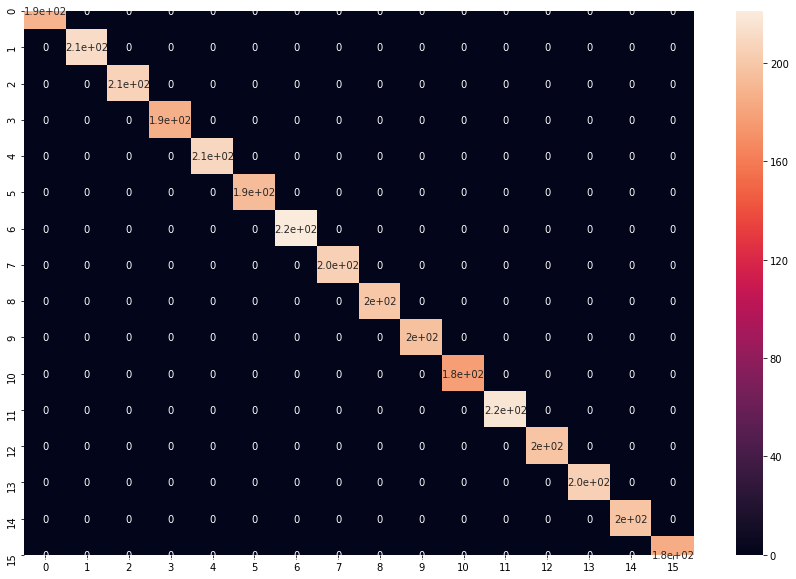

In [21]:
predicts = model.predict(x_test)
n_samples = x_test.shape[0]
pred = np.argmax(predicts, axis=1)
print(accuracy_score(pred,y_test))
array = confusion_matrix(y_test, pred)
cm = pd.DataFrame(array, index = range(n_classes), columns = range(n_classes))
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True)
plt.show()